In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install plotly==4.9.0
!pip install chart_studio

In [3]:
import pandas as pd
import numpy as np

from plotly.offline import iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt 

In [4]:
market_train_df = pd.read_csv("/content/gdrive/My Drive/Forecasting Stock Prices Using News Sentiment Analysis/Datasets/market_train_full.csv")

In [5]:
print(f'{market_train_df.shape[0]} samples and {market_train_df.shape[1]} features in the training market dataset.')

4072956 samples and 17 features in the training market dataset.


In [6]:
market_train_df.drop('Unnamed: 0', inplace = True, axis = 1)

In [7]:
market_train_df.head()


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [8]:
market_train_df['time'] = pd.to_datetime(market_train_df['time'], errors='coerce')

In [9]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
iplot(dict(data=data, layout=layout), filename='basic-line')

In [10]:
data = []
#market_train_df['close'] = market_train_df['close'] / 20
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
iplot(dict(data=data, layout=layout), filename='basic-line')

In [11]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [12]:
grouped[0:5]

time price_diff      
                                   std   min
0 2007-02-01 22:00:00+00:00   0.629012 -6.56
1 2007-02-02 22:00:00+00:00   0.532068 -3.70
2 2007-02-05 22:00:00+00:00   0.566100 -6.51
3 2007-02-06 22:00:00+00:00   0.510355 -2.84
4 2007-02-07 22:00:00+00:00   0.627501 -2.30

In [13]:
print(f"Average standard deviation of price change within a day: {grouped['price_diff']['std'].mean():.4f}.")

Average standard deviation of price change within a day: 1.0335.


In [14]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename='scatter2010')

In [15]:
market_train_df.sort_values('price_diff')[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff
1127598,2010-01-04 22:00:00+00:00,TW.N,Towers Watson & Co,223136.0,50.00,9998.9900,-0.058470,185.988360,-0.056911,163.671298,-0.024316,189.918708,0.034162,188.184866,13.167586,0.0,-9948.9900
627547,2008-09-29 22:00:00+00:00,BK.N,Bank of New York Mellon Corp,18718479.0,26.50,3288.1136,-0.271578,99.125262,-0.064067,98.933405,-0.275164,84.405548,-0.189620,83.371024,4.061628,1.0,-3261.6136
502997,2008-06-05 22:00:00+00:00,AHG.N,Apria Healthcare Group Inc,801892.0,17.29,999.9900,0.009930,58.523214,-0.001831,58.449248,0.104792,62.410907,0.140881,54.556118,-4.176442,0.0,-982.7000
471381,2008-05-06 22:00:00+00:00,CEPH.O,Cephalon Inc,4846.0,61.04,999.9900,0.014628,15.547907,0.009554,14.982480,-0.039950,14.742916,-0.053743,14.824286,0.087719,1.0,-938.9500
242847,2007-09-27 22:00:00+00:00,EXH.N,Archrock Inc,490100.0,79.99,999.9900,0.022236,11.658101,0.018789,11.570153,0.007304,11.618170,0.012866,552.522473,-0.550395,1.0,-920.0000
3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.59,263.8000,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,0.0,-207.2100
7273,2007-02-08 22:00:00+00:00,BA.N,Boeing Co,5155700.0,89.52,200.0000,-0.009186,1.207749,-0.006835,1.202170,0.043010,1.299798,NaN,NaN,0.004434,1.0,-110.4800
375899,2008-02-06 22:00:00+00:00,CME.N,CME Group Inc,8676040.0,485.25,583.4900,-0.175866,-0.061536,-0.165490,-0.023137,-0.204495,0.025448,-0.188712,-0.021896,-0.006932,1.0,-98.2400
628075,2008-09-29 22:00:00+00:00,IBM.N,International Business Machines Corp,9586679.0,114.46,191.9800,-0.041534,0.637915,0.018300,0.634691,-0.006337,0.664182,0.010630,0.666148,0.013094,1.0,-77.5200
3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.19,612.0000,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,0.0,-75.8100


In [16]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])


In [17]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

In 1211 lines price increased by 20% or more.
In 778 lines price decreased by 20% or more.


In [18]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 38 lines price increased by 100% or more.
In 16 lines price decreased by 100% or more.


In [43]:
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

IndexError: ignored

In [44]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values*5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename='scatter2010')

In [21]:
print("Something")

Something


In [22]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
iplot(dict(data=data, layout=layout), filename='basic-line')

In [23]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Trend of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
iplot(dict(data=data, layout=layout), filename='basic-line')

In [24]:
# asset_df = market_train_df[(market_train_df['assetCode'] == 'AAPL.O')]
# asset_df.reset_index().head(10)

In [25]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = market_train_df.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Trend of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
iplot(dict(data=data, layout=layout), filename='basic-line')

In [26]:
# news_train_df = pd.read_csv("/content/gdrive/My Drive/Forecasting Stock Prices Using News Sentiment Analysis/Datasets/news_train_pre2013.csv")
news_train_df = pd.read_csv("/content/gdrive/My Drive/Forecasting Stock Prices Using News Sentiment Analysis/Datasets/news_train.csv")

In [27]:
news_train_df.drop('Unnamed: 0', inplace = True, axis = 1)

In [28]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,NaN,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091367,102,0,0,0,0,0,0,0,0,0,0


In [29]:
print(f'{news_train_df.shape[0]} samples and {news_train_df.shape[1]} features in the training news dataset.')

9328750 samples and 35 features in the training news dataset.


In [30]:
news_train_df.headline = np.where(news_train_df.headline.isnull(), "", news_train_df.headline)

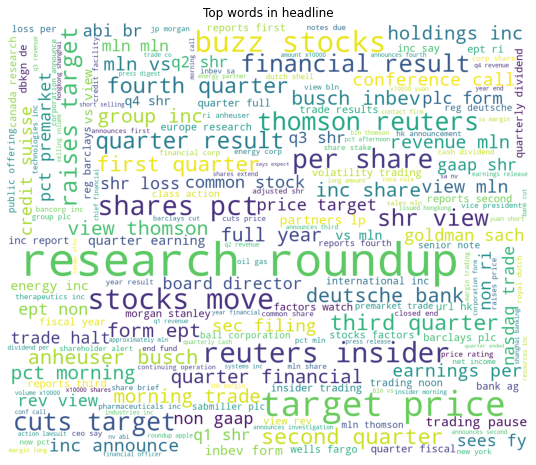

In [31]:
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [32]:
# news_train_df = news_train_df.loc[news_train_df['time'] >= '2010-01-01 22:00:00+0000']

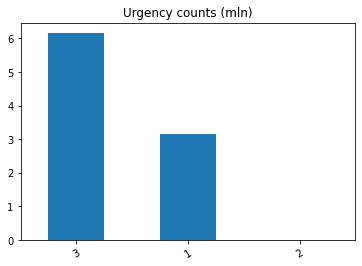

In [33]:
(news_train_df['urgency'].value_counts() / 1000000).plot(kind='bar')
plt.xticks(rotation=30);
plt.title('Urgency counts (mln)');

In [34]:
print(news_train_df['urgency'].value_counts())

3    6162567
1    3166158
2         25
Name: urgency, dtype: int64


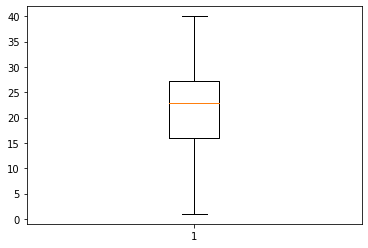

In [35]:
news_train_df['sentence_word_count'] =  news_train_df['wordCount'] / news_train_df['sentenceCount']
plt.boxplot(news_train_df['sentence_word_count'][news_train_df['sentence_word_count'] < 40]);

In [36]:
news_train_df['provider'].value_counts().head(10)

RTRS    7287840
PRN      687327
BSW      659798
MKW      171630
GNW      156367
RNS      119591
LSE       64250
HIIS      61921
CNW       46459
ONE       25233
Name: provider, dtype: int64

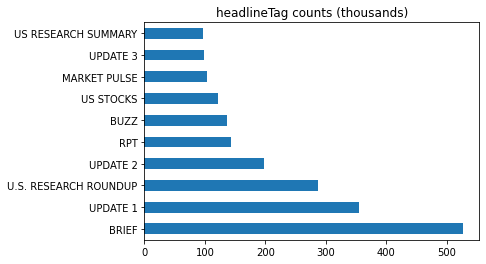

In [37]:
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot(kind='barh');
plt.title('headlineTag counts (thousands)');

In [38]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Citigroup Inc              30823
JPMorgan Chase & Co        29129
Bank of America Corp       28197
Apple Inc                  26702
Goldman Sachs Group Inc    25044
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
Barclays PLC         24898
HSBC Holdings PLC    23191
Deutsche Bank AG     20702
BHP Billiton PLC     18019
Rio Tinto PLC        16782
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Barclays PLC             22855
Apple Inc                22770
General Electric Co      20055
Royal Dutch Shell PLC    18206
Citigroup Inc            18025
Name: assetName, dtype: int64



In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from  datetime import date, datetime, timedelta
from sklearn.metrics import accuracy_score

In [40]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
1126217,2010-01-04 22:00:00+00:00,A.N,Agilent Technologies Inc,2729240.0,31.30,31.39,0.007403,0.011276,-0.002344,0.010532,0.063179,0.065874,0.027270,0.060092,-0.040197,1.0,-0.09,0.997133,38.588223,38.607230
1126218,2010-01-04 22:00:00+00:00,AAI.N,AirTran Holdings Inc,3436803.0,5.18,5.26,-0.007663,0.011538,-0.027851,0.021131,0.005825,0.005736,0.083558,0.030178,0.061253,0.0,-0.08,0.984791,7.031961,7.021656
1126219,2010-01-04 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1701655.0,40.38,40.70,-0.002470,-0.009973,-0.012789,-0.008617,-0.008378,0.002677,-0.021788,-0.001034,-0.034126,1.0,-0.32,0.992138,84.275408,84.301749
1126220,2010-01-04 22:00:00+00:00,AAPL.O,Apple Inc,17633150.0,214.01,213.50,0.015555,0.001830,-0.001329,0.009182,0.115449,0.095602,0.011769,0.067086,-0.035828,1.0,0.51,1.002389,262.223310,262.096429
1126221,2010-01-04 22:00:00+00:00,AAV.N,Advantage Oil & Gas Ltd,833228.0,6.83,6.61,0.047546,-0.003017,0.028141,-0.000661,0.057276,0.037677,0.002492,0.011989,0.005125,0.0,0.22,1.033283,5.957510,5.968219


In [41]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,sentence_word_count
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,NaN,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7,25.000000
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3,16.490909
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.377964,-1,0.450049,0.295671,0.254280,67,0,0,0,0,0,0,0,5,11,17,25.866667
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.149071,-1,0.752917,0.162715,0.084368,83,0,0,0,0,0,0,0,5,13,15,23.214286
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.149071,-1,0.699274,0.209360,0.091367,102,0,0,0,0,0,0,0,0,0,0,23.214286
